# Seasonal Naive Approach

Benchmark model that simply forecasts the same value from the previous seasonal period.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../datasets/hourly-weather-temperature.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(5000, 36)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25 01:00:00,282.75,284.44,287.37,283.15,291.65,290.82,296.72,297.87,291.35,283.54,298.31,297.59,296.60,289.66,277.90,295.29,283.94,294.67,293.20,294.48,291.20,293.32,290.43,296.15,293.03,280.57,284.09,283.98,272.76,279.11,280.356,285.15,284.706,291.056,291.056,285.15
2017-03-25 02:00:00,282.18,283.30,287.21,282.15,290.89,290.15,296.13,297.00,289.14,281.72,295.89,295.53,296.88,288.65,277.42,294.29,279.83,293.67,292.44,293.75,287.14,293.35,288.88,296.04,292.54,279.42,283.17,282.70,272.47,279.34,279.539,285.15,290.150,291.039,291.039,285.15
2017-03-25 03:00:00,281.50,282.58,286.75,281.77,289.29,289.43,294.72,296.32,288.15,279.15,290.44,294.95,295.97,288.17,277.02,293.58,279.57,293.41,291.91,292.84,284.62,292.32,287.32,295.82,291.74,277.86,281.89,282.67,272.46,279.80,279.539,285.15,283.489,291.039,291.039,285.15
2017-03-25 04:00:00,280.83,282.15,286.52,281.26,288.48,288.33,293.52,294.48,286.55,277.30,288.30,294.28,294.79,287.80,276.82,293.17,279.06,292.65,291.88,292.35,280.70,292.34,286.67,295.65,291.02,277.33,281.24,281.60,272.15,279.90,279.539,285.71,288.150,286.150,286.150,285.76
2017-03-25 05:00:00,280.17,282.15,286.07,280.93,287.91,287.60,293.34,292.02,285.56,276.30,287.57,293.42,293.87,287.30,276.68,292.46,278.77,291.65,290.56,291.59,280.56,291.35,286.88,295.87,290.16,276.88,280.38,281.01,272.15,279.74,285.676,285.71,288.150,285.150,285.150,285.76


## Define Parameters

Make predictions for 24-hour period using a seasonality of 24-hours.

In [4]:
dataset_name = 'Hourly Weather Temperature'
dataset_abbr = 'HWT'
model_name = 'Naive'
context_length = 24
prediction_length = 24

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    if len(a) != 0:
        d = np.sum(np.abs(a-b)) / len(a)
    else:
        return 1
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Evaluate Seasonal Naive Model

In [6]:
results = df.copy()
for i, col in enumerate(df.columns):
    results['pred%s' % str(i+1)] = results[col].shift(context_length)
results.dropna(inplace=True)

In [7]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results[col].iloc[-prediction_length:],
                             results['pred%s' % str(i+1)].iloc[-prediction_length:]))

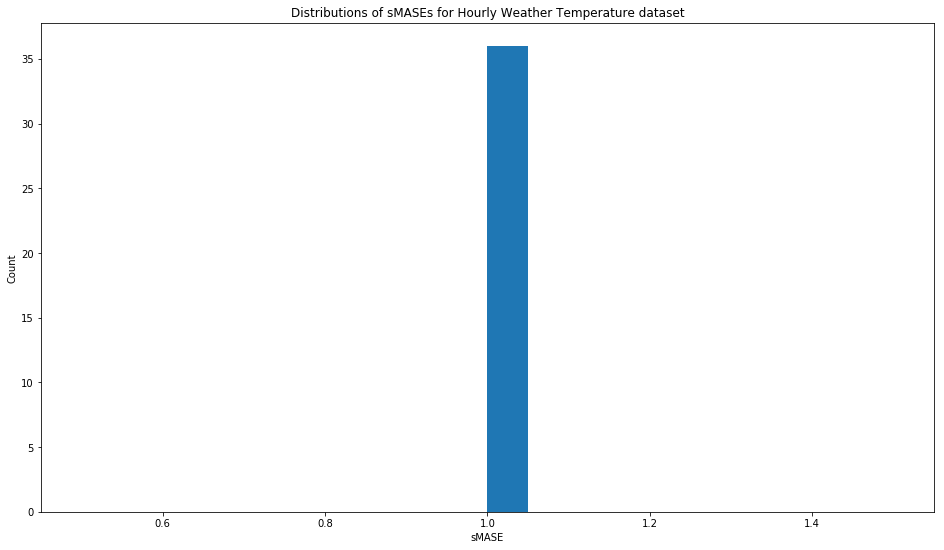

In [8]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [9]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 1.0000


Show some example forecasts.

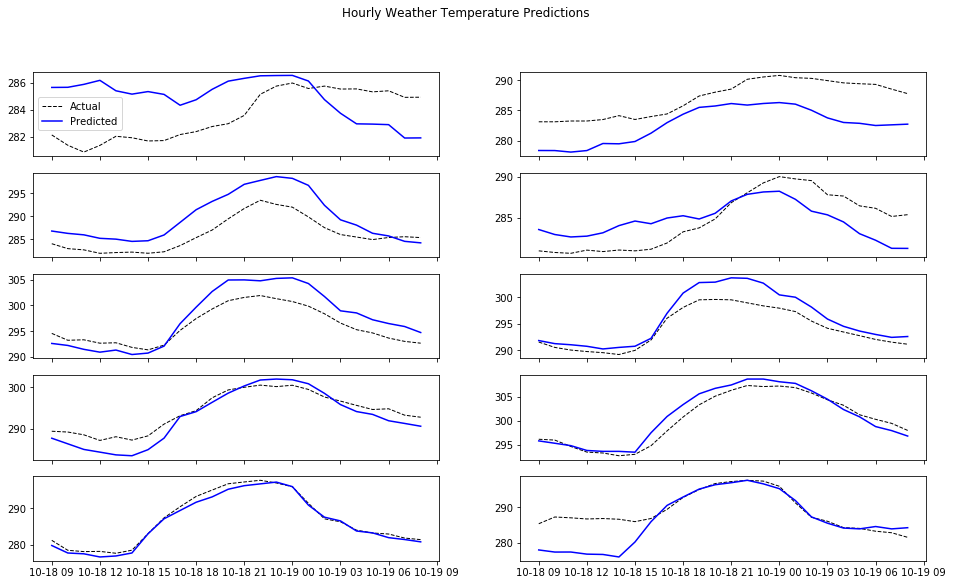

In [10]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 11):
    ax[col-1].plot(results.index[-prediction_length:], results['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results.index[-prediction_length:], results['pred%s' % col].iloc[-prediction_length:],
                   label='Predicted', c='b')
fig.suptitle('{} Predictions'.format(dataset_name))
ax[0].legend();

Store the predictions and accuracy score for the Seasonal Naive Approach models.

In [11]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)